<a href="https://colab.research.google.com/github/matiqiu/mcd-scanveg-ai-model-experiments/blob/main/Exp03_ResNet50_Finetune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1. Importaciones y configuración inicial
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pickle
import os
import shutil
import pandas as pd
from google.colab import files

In [ ]:
# 2. Autenticación de Kaggle
files.upload()  # Subir el token de Kaggle

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# 3. Descarga del Dataset
!kaggle datasets download -d emmarex/plantdisease
!unzip -q plantdisease.zip

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/emmarex/plantdisease
License(s): unknown
100% 658M/658M [00:07<00:00, 90.7MB/s]
100% 658M/658M [00:07<00:00, 88.1MB/s]


In [ ]:
# 3. Descarga del Dataset
!kaggle datasets download -d emmarex/plantdisease
!unzip -q plantdisease.zip

Dataset URL: https://www.kaggle.com/datasets/emmarex/plantdisease
License(s): unknown
plantdisease.zip: Skipping, found more recently modified local copy (use --force to force download)
replace PlantVillage/Pepper__bell___Bacterial_spot/0022d6b7-d47c-4ee2-ae9a-392a53f48647___JR_B.Spot 8964.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# 4. Preparación del Dataset
src_dir = '/content/PlantVillage'
dst_dir = '/content/tomate_10clases'
tomato_classes = [
    'Tomato_Bacterial_spot',
    'Tomato_Early_blight',
    'Tomato_Late_blight',
    'Tomato_Leaf_Mold',
    'Tomato_Septoria_leaf_spot',
    'Tomato_Spider_mites_Two_spotted_spider_mite',
    'Tomato__Target_Spot',
    'Tomato__Tomato_YellowLeaf__Curl_Virus',
    'Tomato__Tomato_mosaic_virus',
    'Tomato_healthy'
]

os.makedirs(dst_dir, exist_ok=True)
for cls in tomato_classes:
    src_cls_path = os.path.join(src_dir, cls)
    dst_cls_path = os.path.join(dst_dir, cls)
    if os.path.isdir(src_cls_path):
        if os.path.exists(dst_cls_path):
            shutil.rmtree(dst_cls_path)
        shutil.copytree(src_cls_path, dst_cls_path)
    else:
        print(f"⚠️  Clase no encontrada: {cls}")

print("Carpetas copiadas:")
print(sorted(os.listdir(dst_dir)))

Carpetas copiadas:
['Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


In [ ]:
# 5. Generadores de Datos
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 10
EPOCHS = 14  # Total de épocas

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    dst_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    dst_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 12813 images belonging to 10 classes.
Found 3198 images belonging to 10 classes.


In [ ]:
# 6. Construcción del Modelo
base_model = ResNet50V2(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

# Primera Fase: Congelar todas las capas del modelo base
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),  # Tasa de aprendizaje más alta
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
# 7. Callbacks y Entrenamiento (Primera Fase)
EXPERIMENT_NAME = "exp03_resnet50_finetune"
model_path_phase1 = f'/content/drive/MyDrive/PROYECTO/{EXPERIMENT_NAME}_phase1.keras'
history_path_phase1 = f'/content/drive/MyDrive/PROYECTO/{EXPERIMENT_NAME}_phase1_history.pkl'

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint(model_path_phase1, save_best_only=True)
]

history1 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS // 2,  # Primera mitad de las épocas
    callbacks=callbacks
)

# Guardar el progreso después de la primera fase
model.save(model_path_phase1)
with open(history_path_phase1, 'wb') as f:
    pickle.dump(history1.history, f)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/7
401/401 ━━━━━━━━━━━━━━━━━━━━ 2605s 6s/step - accuracy: 0.5307 - loss: 1.4320 - val_accuracy: 0.8014 - val_loss: 0.6255
Epoch 2/7
401/401 ━━━━━━━━━━━━━━━━━━━━ 2556s 6s/step - accuracy: 0.7884 - loss: 0.6496 - val_accuracy: 0.8352 - val_loss: 0.5145
Epoch 3/7
401/401 ━━━━━━━━━━━━━━━━━━━━ 2568s 6s/step - accuracy: 0.8175 - loss: 0.5467 - val_accuracy: 0.8465 - val_loss: 0.4531
Epoch 4/7
401/401 ━━━━━━━━━━━━━━━━━━━━ 2543s 6s/step - accuracy: 0.8322 - loss: 0.5087 - val_accuracy: 0.8565 - val_loss: 0.4308
Epoch 5/7
401/401 ━━━━━━━━━━━━━━━━━━━━ 2581s 6s/step - accuracy: 0.8410 - loss: 0.4831 - val_accuracy: 0.8659 - val_loss: 0.4007
Epoch 6/7
401/401 ━━━━━━━━━━━━━━━━━━━━ 2617s 7s/step - accuracy: 0.8454 - loss: 0.4677 - val_accuracy: 0.8762 - val_loss: 0.3937
Epoch 7/7
401/401 ━━━━━━━━━━━━━━━━━━━━ 2662s 7s/step - accuracy: 0.8456 - loss: 0.4567 - val_accuracy: 0.8715 - val_loss: 0.4051


In [ ]:
# 8. Segunda Fase: Descongelar las últimas 20 capas del modelo base
print("Capas entrenables antes de descongelar:", len(model.trainable_variables))
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False
print("Capas entrenables después de descongelar:", len(model.trainable_variables))

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # Tasa de aprendizaje más baja
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


Capas entrenables antes de descongelar: 2
Capas entrenables después de descongelar: 19


In [ ]:
# 9. Callbacks y Entrenamiento (Segunda Fase)
model_path_phase2 = f'/content/drive/MyDrive/PROYECTO/{EXPERIMENT_NAME}_phase2.keras'
history_path_phase2 = f'/content/drive/MyDrive/PROYECTO/{EXPERIMENT_NAME}_phase2_history.pkl'

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint(model_path_phase2, save_best_only=True)
]

# Asegurarse que la época inicial es la correcta
initial_epoch = history1.epoch[-1] + 1

history2 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,  # Usar el número total de épocas
    initial_epoch=initial_epoch,  # Comenzar desde la epoca 7
    callbacks=callbacks
)

# Guardar el progreso final después de la segunda fase
model.save(model_path_phase2)
with open(history_path_phase2, 'wb') as f:
    pickle.dump(history2.history, f)

Epoch 8/14
401/401 ━━━━━━━━━━━━━━━━━━━━ 3309s 8s/step - accuracy: 0.7083 - loss: 0.9541 - val_accuracy: 0.8712 - val_loss: 0.3908
Epoch 9/14
401/401 ━━━━━━━━━━━━━━━━━━━━ 3243s 8s/step - accuracy: 0.8587 - loss: 0.4270 - val_accuracy: 0.8790 - val_loss: 0.3461
Epoch 10/14
401/401 ━━━━━━━━━━━━━━━━━━━━ 3295s 8s/step - accuracy: 0.8788 - loss: 0.3604 - val_accuracy: 0.8971 - val_loss: 0.3062
Epoch 11/14
401/401 ━━━━━━━━━━━━━━━━━━━━ 3261s 8s/step - accuracy: 0.8905 - loss: 0.3218 - val_accuracy: 0.9103 - val_loss: 0.2747
Epoch 12/14
401/401 ━━━━━━━━━━━━━━━━━━━━ 3304s 8s/step - accuracy: 0.8961 - loss: 0.2951 - val_accuracy: 0.9131 - val_loss: 0.2598
Epoch 13/14
401/401 ━━━━━━━━━━━━━━━━━━━━ 3272s 8s/step - accuracy: 0.9056 - loss: 0.2684 - val_accuracy: 0.9115 - val_loss: 0.2486
Epoch 14/14
401/401 ━━━━━━━━━━━━━━━━━━━━ 3218s 8s/step - accuracy: 0.9198 - loss: 0.2340 - val_accuracy: 0.9234 - val_loss: 0.2299


In [ ]:
# 9. Evaluación y Visualización
val_gen.reset()
y_pred_prob = model.predict(val_gen, verbose=0)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = val_gen.classes

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='weighted')
rec = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {acc}")
print(f"Precision: {prec}")
print(f"Recall: {rec}")
print(f"F1-score: {f1}")


Accuracy: 0.9262038774233896
Precision: 0.925952958383613
Recall: 0.9262038774233896
F1-score: 0.9259625906979347


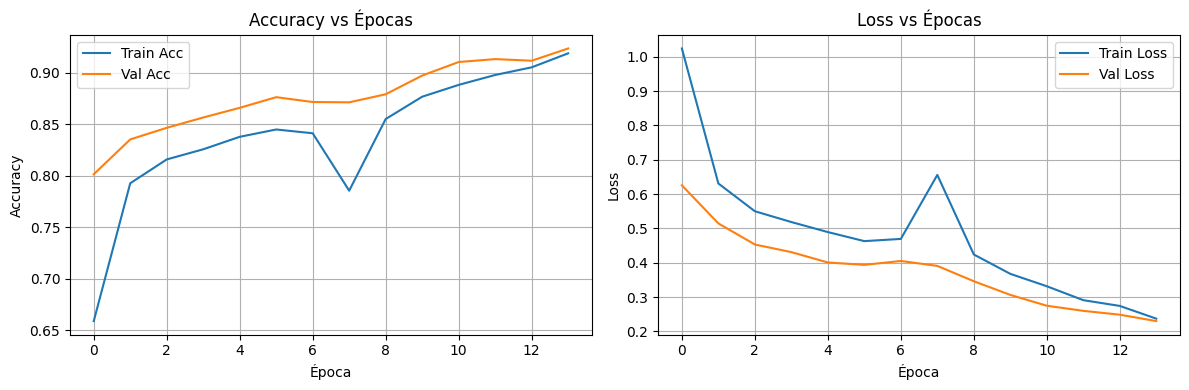

In [ ]:
# 10. Gráficos de métricas
hist_df1 = pd.DataFrame(history1.history)
hist_df2 = pd.DataFrame(history2.history)
hist_df = pd.concat([hist_df1, hist_df2], ignore_index=True)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(hist_df['accuracy'], label='Train Acc')
plt.plot(hist_df['val_accuracy'], label='Val Acc')
plt.title('Accuracy vs Épocas'); plt.xlabel('Época'); plt.ylabel('Accuracy')
plt.legend(); plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(hist_df['loss'], label='Train Loss')
plt.plot(hist_df['val_loss'], label='Val Loss')
plt.title('Loss vs Épocas'); plt.xlabel('Época'); plt.ylabel('Loss')
plt.legend(); plt.grid(True)
plt.tight_layout()
plt.savefig(f'/content/{EXPERIMENT_NAME}_curvas.png', dpi=300)
plt.show()

Found 3198 images belonging to 10 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


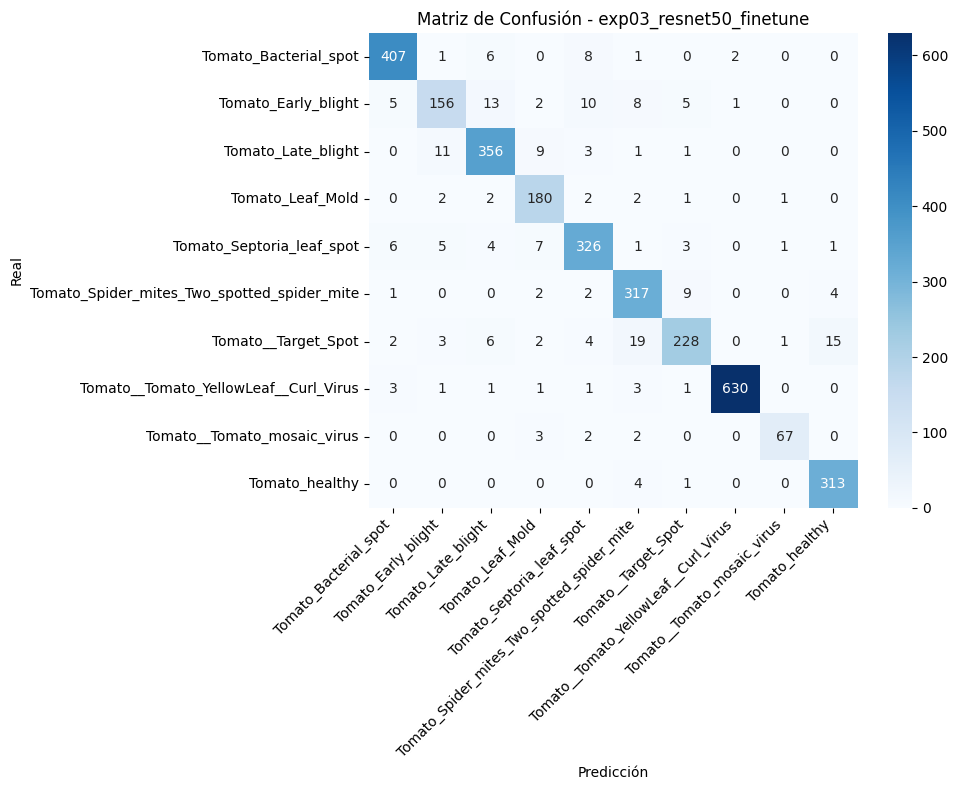

In [ ]:
# 11. Matriz de confusión
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# --- Definiciones necesarias para que la celda sea autónoma ---
dst_dir = '/content/tomate_10clases'
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
# -------------------------------------------------------------

# Re-crear el generador de validación para asegurar que exista
datagen_val = ImageDataGenerator(rescale=1./255, validation_split=0.2)

val_gen = datagen_val.flow_from_directory(
    dst_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Asegurarse que las variables de predicción existan
y_pred_prob = model.predict(val_gen, verbose=0)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = val_gen.classes

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=val_gen.class_indices.keys(), yticklabels=val_gen.class_indices.keys())
plt.title(f'Matriz de Confusión - {EXPERIMENT_NAME}')
plt.xlabel('Predicción'); plt.ylabel('Real')
plt.xticks(rotation=45, ha='right'); plt.tight_layout()
plt.savefig(f'/content/{EXPERIMENT_NAME}_matrix.png', dpi=300)
plt.show()

In [ ]:
# 1. Montar Google Drive para acceder al modelo guardado
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 2. Autenticación de Kaggle y preparación del dataset
from google.colab import files
import os
import shutil

# Subir el token de Kaggle si no existe
if not os.path.exists('/root/.kaggle/kaggle.json'):
    print("Por favor, sube tu archivo kaggle.json")
    files.upload()
    !mkdir -p ~/.kaggle
    !mv kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
else:
    print("El archivo kaggle.json ya existe.")

# Re-ejecutar la descarga y preparación del dataset
!kaggle datasets download -d emmarex/plantdisease --force
!unzip -oq plantdisease.zip -d /content/

src_dir = '/content/PlantVillage'
dst_dir = '/content/tomate_10clases'
tomato_classes = [
    'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight',
    'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot',
    'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot',
    'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus',
    'Tomato_healthy'
]

os.makedirs(dst_dir, exist_ok=True)
for cls in tomato_classes:
    src_cls_path = os.path.join(src_dir, cls)
    dst_cls_path = os.path.join(dst_dir, cls)
    if os.path.isdir(src_cls_path):
        if os.path.exists(dst_cls_path):
            shutil.rmtree(dst_cls_path)
        shutil.copytree(src_cls_path, dst_cls_path)

print("\nCarpetas de datos recreadas exitosamente.")

Por favor, sube tu archivo kaggle.json


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/emmarex/plantdisease
License(s): unknown
 97% 638M/658M [00:03<00:00, 189MB/s]
100% 658M/658M [00:03<00:00, 202MB/s]

Carpetas de datos recreadas exitosamente.


In [ ]:
# 3. Cargar el modelo final ya entrenado desde Drive
import tensorflow as tf

EXPERIMENT_NAME = "exp03_resnet50_finetune"
model_path_phase2 = f'/content/drive/MyDrive/PROYECTO/{EXPERIMENT_NAME}_phase2.keras'

# Cargar el modelo
model = tf.keras.models.load_model(model_path_phase2)

print("Modelo entrenado cargado exitosamente desde Google Drive.")

Modelo entrenado cargado exitosamente desde Google Drive.


### 4. Ahora sí, ejecuta la celda de la Matriz de Confusión

Ya que hemos recreado los datos y cargado el modelo entrenado, la celda 11 (`lVW3y0J6ro1o`) debería funcionar sin problemas y sin necesidad de volver a entrenar.